In [1]:
using Revise
includet("../codebase/mlp.jl")
includet("../codebase/rewiring.jl")
using Knet, Plots, Statistics, LinearAlgebra, Random, .mlp

In [313]:
n = 12 # length of input bit array
xdim = n
h1=h2=h3=2*n # hidden layer sizes
ydim = 1 # output is the probability for even parity
nbatch = 100 # number of bit strings presented at each iteration
ntest = div(2^n,8) # keep 1/8-th as test set
niter = 9*10^4 # number of training iterations
LR = 0.1
p = 0.0

0.0

In [314]:
# NN parameters
w1 = Param(randn(h1,xdim))
b1 = Param(randn(h1))
w2 = Param(randn(h2,h1))
b2 = Param(randn(h2))
w3 = Param(randn(h3,h2))
b3 = Param(randn(h3))
w4 = Param(randn(1,h3))
b4 = Param(randn(1))
w = (w1,w2,w3,w4)
b = (b1,b2,b3,b4)
layer_dims = (xdim, h1, h2, h3, ydim)

(12, 24, 24, 24, 1)

In [315]:
for i=1:length(w)
    s1 = size(w[i],1) 
    s2 = size(w[i],2) 
    w[i] .*= abs.(rand(1:3,s1, s2).-2) # generates another matrix with same dimensions including either
                                                       # 0 or 1 as elements with ~1:2 ratio, multiplies with w[i]
                                                        # deletes overall 1/3
    
    println("Sparsity of layer#", i, " ", sum(map(i -> i == 0.0 ? 1 : 0,w[i]))/(s1*s2))
end


Sparsity of layer#1 0.2708333333333333
Sparsity of layer#2 0.3611111111111111
Sparsity of layer#3 0.3142361111111111
Sparsity of layer#4 0.5


In [316]:
# training and test set, a different subset is selected every 1000 iterations in training
trainidx, testidx = mlp.gen_data(n, ntest)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 11  …  4084, 4085, 4086, 4087, 4088, 4089, 4092, 4093, 4094, 4095], [3632, 1555, 909, 2752, 3846, 3471, 2122, 3416, 186, 1157  …  3287, 815, 2335, 2626, 1669, 3312, 2508, 3835, 3579, 3638])

In [ ]:
losstrn = [0.0]
losstst = [0.0]    
losscheck = [Inf]
xtrn, ytrn, xtst, ytst = mlp.split_data(trainidx, testidx, n, ntest)
    
for k in progress(1:niter)
    dw = []
    W = Param(rewiring.computeKernel(w, layer_dims))
    
    xin = genbatch(trainidx, n,nbatch, ntest)
    yin = sum(xin,dims=1).%2
    dl = @diff loss(w,b,xin,yin; λ= 0.0)
    
  """  s = 1
    for i=1:length(layer_dims)
        W[s:s+layer_dims[i],:] .-=  LR * grad(dl,W[s:s+layer_dims[i],:]) 
        b[i] .-= LR *grad(dl,b[i])
        s += layer_dims[i]
    end"""
    
        for i=1:length(w)
            w[i] .-= LR *grad(dl,w[i])
            b[i] .-= LR *grad(dl,b[i])
            push!(dw, grad(dl,w[i]))
        end
    
    if (k%1000==1)
        W = rewiring.computeKernel(w,layer_dims) #  adjacency  matrix of weights, 85x85
        D = rewiring.computeKernel(dw,layer_dims) # dw values as a 85x85 matrix
        W_wired = rewiring.rewireOutdegree(W, D, p, layer_dims)
        w = rewiring.computeKernel_reverse(w, W_wired, layer_dims)

            
        xin = genbatch(trainidx, n,ntest, ntest) # training set samples with size equal to test set
        yin = sum(xin,dims=1).%2 
        push!(losstrn,loss(w,b,xin,yin; λ= 0.0)) # record loss over 1000 samples
        push!(losstst,loss(w,b,xtst,ytst; λ= 0.0))
            
        if (losscheck[end]-losstrn[end]) < 0 
            println("Loss increasing")
            w = rewiring.computeKernel_reverse(w, W, layer_dims)
        else
            push!(losscheck,loss(w,b,xtrn,ytrn; λ= 0.0)) # checkpoint loss when rewiring is accepted    
        end
    end    
end

┣                    ┫ [0.00%, 1/90000, 00:00/00:00, 282326.37i/s] 

Rewiring: non-head (22,45) with head (25, 45)


┣▎                   ┫ [1.42%, 1280/90000, 00:01/01:10, 1278.71i/s] 

Rewiring: non-head (46,77) with head (38, 77)


┣█▎                  ┫ [6.34%, 5707/90000, 00:04/01:03, 1437.88i/s] 

Loss increasing


┣██▍                 ┫ [12.33%, 11098/90000, 00:08/01:05, 1463.78i/s] 

Rewiring: non-head (46,82) with head (56, 82)


┣██▊                 ┫ [13.84%, 12452/90000, 00:09/01:06, 1353.26i/s] 

Rewiring: non-head (46,62) with head (60, 62)


┣███▍                ┫ [17.05%, 15344/90000, 00:11/01:05, 1460.34i/s] 

Loss increasing


┣███▉                ┫ [19.83%, 17848/90000, 00:13/01:06, 1141.21i/s] 

Rewiring: non-head (20,60) with head (28, 60)
Loss increasing


┣████▏               ┫ [21.16%, 19043/90000, 00:14/01:07, 1194.81i/s] 

Rewiring: non-head (46,76) with head (56, 76)


┣██████▍             ┫ [31.88%, 28692/90000, 00:21/01:06, 1468.56i/s] 

Loss increasing


┣██████▋             ┫ [33.46%, 30118/90000, 00:22/01:06, 1425.30i/s] 

Loss increasing


┣██████▉             ┫ [34.97%, 31474/90000, 00:23/01:06, 1355.33i/s] 

Rewiring: non-head (18,56) with head (26, 56)


┣███████▎            ┫ [36.40%, 32764/90000, 00:24/01:06, 1289.57i/s] 

Rewiring: non-head (18,46) with head (21, 46)
Loss increasing
Loss increasing


┣███████▌            ┫ [37.95%, 34152/90000, 00:25/01:06, 1366.21i/s] 

Loss increasing


┣████████▏           ┫ [40.97%, 36877/90000, 00:27/01:06, 1282.74i/s] 

Loss increasing


┣████████▌           ┫ [42.66%, 38392/90000, 00:28/01:06, 1514.60i/s] 

Rewiring: non-head (12,18) with head (6, 18)


┣████████▊           ┫ [44.14%, 39729/90000, 00:29/01:06, 1336.65i/s] 

Loss increasing
Rewiring: non-head (18,42) with head (34, 42)
Loss increasing


┣█████████▏          ┫ [45.70%, 41127/90000, 00:30/01:06, 1365.34i/s] 

Loss increasing


┣█████████▍          ┫ [47.39%, 42650/90000, 00:31/01:06, 1522.55i/s] 

Loss increasing


┣█████████▊          ┫ [48.93%, 44036/90000, 00:32/01:06, 1385.39i/s] 

Loss increasing


┣██████████          ┫ [50.49%, 45437/90000, 00:33/01:06, 1400.88i/s] 

Rewiring: non-head (18,44) with head (19, 44)


┣██████████▋         ┫ [53.50%, 48147/90000, 00:35/01:06, 1243.79i/s] 

Rewiring: non-head (18,40) with head (22, 40)


┣███████████▎        ┫ [56.54%, 50883/90000, 00:37/01:06, 1312.54i/s] 

Rewiring: non-head (18,47) with head (27, 47)
Rewiring: non-head (22,56) with head (18, 56)


┣███████████▌        ┫ [58.11%, 52297/90000, 00:38/01:06, 1413.20i/s] 

Rewiring: non-head (18,55) with head (36, 55)


┣███████████▉        ┫ [59.60%, 53643/90000, 00:39/01:06, 1345.65i/s] 

Loss increasing
Rewiring: non-head (46,83) with head (60, 83)
Loss increasing


┣████████████▏       ┫ [61.22%, 55097/90000, 00:40/01:06, 1375.41i/s] 

Loss increasing


┣████████████▌       ┫ [62.90%, 56610/90000, 00:41/01:06, 1512.58i/s] 

Loss increasing


┣████████████▉       ┫ [64.43%, 57988/90000, 00:42/01:06, 1377.38i/s] 

Rewiring: non-head (18,56) with head (22, 56)


┣█████████████▌      ┫ [67.64%, 60879/90000, 00:44/01:05, 1467.46i/s] 

Loss increasing


┣██████████████▏     ┫ [70.80%, 63724/90000, 00:46/01:05, 1357.48i/s] 

Loss increasing


┣██████████████▊     ┫ [74.00%, 66596/90000, 00:48/01:05, 1445.88i/s] 

Rewiring: non-head (18,57) with head (34, 57)
Loss increasing


┣███████████████▍    ┫ [77.13%, 69414/90000, 00:50/01:05, 1384.84i/s] 

Loss increasing


┣████████████████    ┫ [80.40%, 72364/90000, 00:52/01:05, 1433.60i/s] 

In [ ]:
plot(losstrn[1:end])
plot!(losstst[1:end]) 

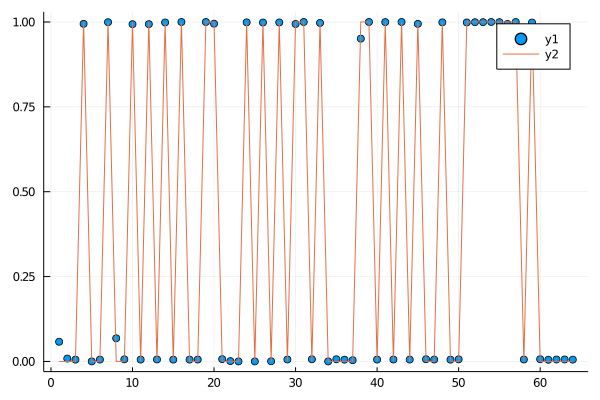

In [302]:
np=min(ntest,64)
scatter(pred(w,b,xtst)[1:np]
#    ,xlim=(0,np)
)
plot!(ytst[1:np])

In [303]:
# accuracy
function acc(x,y)
    cnt = 0
    tot = length(x[1,:])
    for i=1:tot-1
        chk = (pred(w,b,x[:,i])[1] - y[i][1])^2
        if (chk < 0.5)
            cnt += 1
        end
    end
    return 1.0*cnt/tot
end

trainidx, testidx = mlp.gen_data(n, ntest)
xtrn, ytrn, xtst, ytst = mlp.split_data(trainidx, testidx, n, ntest)

([0 0 … 1 1; 0 0 … 1 1; … ; 0 1 … 1 1; 1 1 … 0 1], [1 0 … 1 0], [1 1 … 0 1; 1 0 … 1 1; … ; 0 0 … 1 1; 1 1 … 1 1], [0 0 … 0 1])

In [304]:
acc(xtrn,ytrn),acc(xtst,ytst)

(0.9938598939436226, 0.9921875)

In [305]:
# acc over 100 trials
sumtrn = 0.0; sumtst = 0.0

for i=1:100
    trainidx, testidx = mlp.gen_data(n, ntest)
    xtrn, ytrn, xtst, ytst = mlp.split_data(trainidx, testidx, n, ntest)
    sumtrn += acc(xtrn,ytrn); sumtst += acc(xtst,ytst)
end

(sumtrn/100,sumtst/100) 

(0.9938403572425336, 0.99234375)

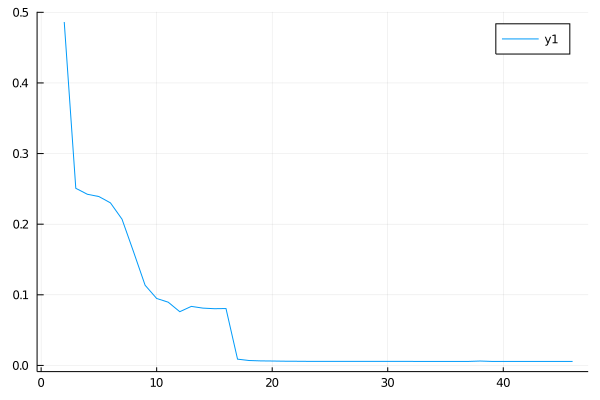

In [306]:
# loss change between rewiring checkpoints,
# only loss values in rewiring iterations included
plot(losscheck)